# Посмотрим, как работает DataPreprocessor
## протестируем на синтетических данных

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from data_preprocessor import DataPreprocessor


In [34]:
np.random.seed(21)

data = {
    'age': np.random.randint(18, 70, 100),
    'salary': np.random.normal(50000, 15000, 100),
    'department': np.random.choice(['IT', 'HR', 'Sales', 'Finance', 'Marketing', 'Operations'], 100),
    'experience': np.random.randint(0, 30, 100),
    'city': np.random.choice(['Moscow', 'London', 'Berlin', 'Paris'], 100),
    'bonus': np.random.choice(['Yes', 'No'], 100),
    'score': np.random.uniform(0, 100, 100),
    'useless_column': [np.nan if np.random.rand() > 0.3 else 1 for _ in range(100)]
}

df_synthetic = pd.DataFrame(data)

for col in ['age', 'salary', 'department']:
    idx = np.random.choice(100, size=20, replace=False)
    df_synthetic.loc[idx, col] = np.nan

for col in ['age', 'experience']:
    df_synthetic[col] = df_synthetic[col].astype(float)

print("Синтетические данные для демонстрации")
print(df_synthetic.head(10))
print(f"Размер: {df_synthetic.shape}")

preprocessor = DataPreprocessor(df_synthetic)
processed_df = preprocessor.fit_transform(
    missing_threshold=0.5,
    missing_strategy='median',
    encode_max_categories=6,
    normalize_method='minmax'
)

print(f"\n Обработанные данные:")
print(processed_df.head(10))

Синтетические данные для демонстрации
    age        salary  department  experience    city bonus      score  useless_column
0  27.0           NaN   Marketing        29.0  London    No  78.009324             NaN
1   NaN  75193.264615         NaN        18.0   Paris    No  61.277200             NaN
2  22.0  56227.428111         NaN         5.0   Paris   Yes  97.449572             NaN
3   NaN  61215.224059       Sales        23.0  Moscow    No  80.906193             1.0
4  66.0  44112.043909     Finance        18.0  Berlin    No  76.005798             NaN
5  53.0  43905.138915   Marketing         8.0  London   Yes  27.126254             1.0
6  52.0           NaN  Operations        14.0  Moscow   Yes   5.486095             NaN
7  67.0  65013.532656  Operations        19.0  London    No  33.177471             NaN
8  28.0  43284.763519         NaN         0.0   Paris   Yes  81.574095             NaN
9  26.0           NaN          HR        21.0   Paris    No   6.178194             NaN
Разме

## посмотрим на готовых реальных датасетах: California Housing, Titanic

In [35]:
#Загрузка датасетов

# California Housing
california = fetch_california_housing()
df_california = pd.DataFrame(california.data, columns=california.feature_names)
df_california['MedHouseVal'] = california.target
df_california['HouseAgeGroup'] = pd.cut(df_california['HouseAge'],
                                        bins=[0, 10, 30, 50, 100],
                                        labels=['New', 'Young', 'Middle', 'Old'])

df_california['IncomeGroup'] = pd.qcut(df_california['MedInc'], 4,
                                       labels=['Low', 'Medium', 'High', 'VeryHigh'])
np.random.seed(21)
for col in ['AveRooms', 'Population', 'AveOccup']:
    mask = np.random.rand(len(df_california)) < 0.15
    df_california.loc[mask, col] = np.nan

print(f"\n1.California Housing: {df_california.shape}")
print(df_california.head())

# Titanic
df_titanic = sns.load_dataset('titanic')
df_titanic = df_titanic[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class']]
mask = np.random.rand(len(df_titanic)) < 0.1
df_titanic.loc[mask, 'age'] = np.nan
mask = np.random.rand(len(df_titanic)) < 0.05
df_titanic.loc[mask, 'fare'] = np.nan
print(f"\n2.Titanic: {df_titanic.shape}")
print(df_titanic.head())


1.California Housing: (20640, 11)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  Longitude  MedHouseVal HouseAgeGroup IncomeGroup
0  8.3252      41.0       NaN   1.023810       322.0       NaN     37.88    -122.23        4.526        Middle    VeryHigh
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86    -122.22        3.585         Young    VeryHigh
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85    -122.24        3.521           Old    VeryHigh
3  5.6431      52.0       NaN   1.073059       558.0  2.547945     37.85    -122.25        3.413           Old    VeryHigh
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85    -122.25        3.422           Old        High

2.Titanic: (891, 9)
   survived  pclass     sex   age  sibsp  parch     fare embarked  class
0         0       3    male  22.0      1      0   7.2500        S  Third
1         1       1  female  38.0      1      0  71.2833    

## анализ данных до обработки

In [40]:
def analyze_dataset(df, title):
    print(f"Размер: {df.shape}")
    print(f"\nТипы данных:")
    dtypes_count=df.dtypes.value_counts()
    for dtype, count in dtypes_count.items():
        print(f"{dtype}: {count}")

    print(f"\nПропущенные значения:")
    missing=df.isnull().sum()
    missing=missing[missing > 0]
    if len(missing) > 0:
        for col in missing.index:
            print(f"{col}: {missing[col]} пропусков ({(missing[col]/len(df)*100):.1f}%)")
    else:
        print("Нет пропущенных значений")

    print(f"\nЧисловые признаки:")
    try:
        numeric_cols=df.select_dtypes(include=['number']).columns
    except:
        numeric_cols=df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"Количество: {len(numeric_cols)}")
        print(f"Примеры: {list(numeric_cols[:3])}")

    print(f"\nКатегориальные признаки:")
    try:
        cat_cols=df.select_dtypes(include=['object', 'category', 'string']).columns
    except:
        cat_cols=df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print(f"Количество: {len(cat_cols)}")
        for col in cat_cols[:3]:
            print(f"{col}: {df[col].nunique()} уникальных значениц")

analyze_dataset(df_california, "California Housing")
analyze_dataset(df_titanic, "Titanic Dataset")

Размер: (20640, 11)

Типы данных:
float64: 9
category: 1
category: 1

Пропущенные значения:
AveRooms: 3082 пропусков (14.9%)
Population: 3128 пропусков (15.2%)
AveOccup: 3072 пропусков (14.9%)

Числовые признаки:
Количество: 9
Примеры: ['MedInc', 'HouseAge', 'AveRooms']

Категориальные признаки:
Количество: 2
HouseAgeGroup: 4 уникальных значениц
IncomeGroup: 4 уникальных значениц
Размер: (891, 9)

Типы данных:
int64: 4
object: 2
float64: 2
category: 1

Пропущенные значения:
age: 240 пропусков (26.9%)
fare: 38 пропусков (4.3%)
embarked: 2 пропусков (0.2%)

Числовые признаки:
Количество: 6
Примеры: ['survived', 'pclass', 'age']

Категориальные признаки:
Количество: 3
sex: 2 уникальных значениц
embarked: 3 уникальных значениц
class: 3 уникальных значениц


## обработка California Housing

In [41]:
preprocessor_ca=DataPreprocessor(df_california)
processed_ca=preprocessor_ca.fit_transform(
    missing_threshold=0.3,
    missing_strategy='median',
    encode_max_categories=5,
    normalize_method='std'
)

print(f"До обработки: {df_california.shape}")
print(f"После обработки: {processed_ca.shape}")
info_ca=preprocessor_ca.get_transformation_info()
print(f"Удаленные столбцы: {info_ca['removed_columns']}")
print(f"One-hot столбцов создано: {len(info_ca['one_hot_columns'])}")
print(f"Нормализовано столбцов: {len(info_ca['scalers'])}")
print(processed_ca.head(10))

До обработки: (20640, 11)
После обработки: (20640, 15)
Удаленные столбцы: []
One-hot столбцов создано: 6
Нормализовано столбцов: 15
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  Longitude  MedHouseVal  HouseAgeGroup_Young  HouseAgeGroup_Middle  HouseAgeGroup_Old  IncomeGroup_Medium  IncomeGroup_High  IncomeGroup_VeryHigh
0  2.344766  0.982143 -0.072539  -0.153758   -1.004895 -0.030300  1.052548  -1.327835     2.129631            -0.930328              1.234941          -0.261492           -0.577350         -0.577350              1.732051
1  2.332238 -0.607019  0.353432  -0.263336    0.951853 -0.153575  1.043185  -1.322844     1.314156             1.074890             -0.809755          -0.261492           -0.577350         -0.577350              1.732051
2  1.782699  1.856182  1.224073  -0.049016   -0.841127 -0.033480  1.038503  -1.332827     1.258693            -0.930328             -0.809755           3.824203           -0.577350         -0.577350       

## обработка Titanic

In [42]:
preprocessor_titanic=DataPreprocessor(df_titanic)
processed_titanic=preprocessor_titanic.fit_transform(
    missing_threshold=0.1,
    missing_strategy='mean',
    encode_max_categories=3,
    normalize_method='minmax'
)

print(f"  До обработки: {df_titanic.shape}")
print(f"  После обработки: {processed_titanic.shape}")
print(processed_titanic.head(10))

  До обработки: (891, 9)
  После обработки: (891, 10)
   survived  pclass  sibsp     parch      fare  sex_male  embarked_Q  embarked_S  class_Second  class_Third
0       0.0     1.0  0.125  0.000000  0.014151       1.0         0.0         1.0           0.0          1.0
1       1.0     0.0  0.125  0.000000  0.139136       0.0         0.0         0.0           0.0          0.0
2       1.0     1.0  0.000  0.000000  0.015469       0.0         0.0         1.0           0.0          1.0
3       1.0     0.0  0.125  0.000000  0.103644       0.0         0.0         1.0           0.0          0.0
4       0.0     1.0  0.000  0.000000  0.015713       1.0         0.0         1.0           0.0          1.0
5       0.0     1.0  0.000  0.000000  0.016510       1.0         1.0         0.0           0.0          1.0
6       0.0     0.0  0.000  0.000000  0.101229       1.0         0.0         1.0           0.0          0.0
7       0.0     1.0  0.375  0.166667  0.041136       1.0         0.0         1.0  

## сравнение разных стратегий обработки


 Стратегия 1: {'missing_strategy': 'mean', 'normalize_method': 'std'}
   Среднее значение признаков: -0.0000
   Среднее std признаков: 1.0006
   Диапазон: [-1.6238, 9.7246]

 Стратегия 2: {'missing_strategy': 'median', 'normalize_method': 'std'}
   Среднее значение признаков: -0.0000
   Среднее std признаков: 1.0006
   Диапазон: [-1.6238, 9.7137]

 Стратегия 3: {'missing_strategy': 'mean', 'normalize_method': 'minmax'}
   Среднее значение признаков: 0.3447
   Среднее std признаков: 0.3382
   Диапазон: [0.0000, 1.0000]

 Стратегия 4: {'missing_strategy': 'median', 'normalize_method': 'minmax'}
   Среднее значение признаков: 0.3446
   Среднее std признаков: 0.3382
   Диапазон: [0.0000, 1.0000]


  strategy normalization          mean       std       min       max
0     mean           std -1.515187e-17  1.000562 -1.623803  9.724618
1   median           std -2.571830e-17  1.000562 -1.623803  9.713653
2     mean        minmax  3.447248e-01  0.338174  0.000000  1.000000
3   median        mi

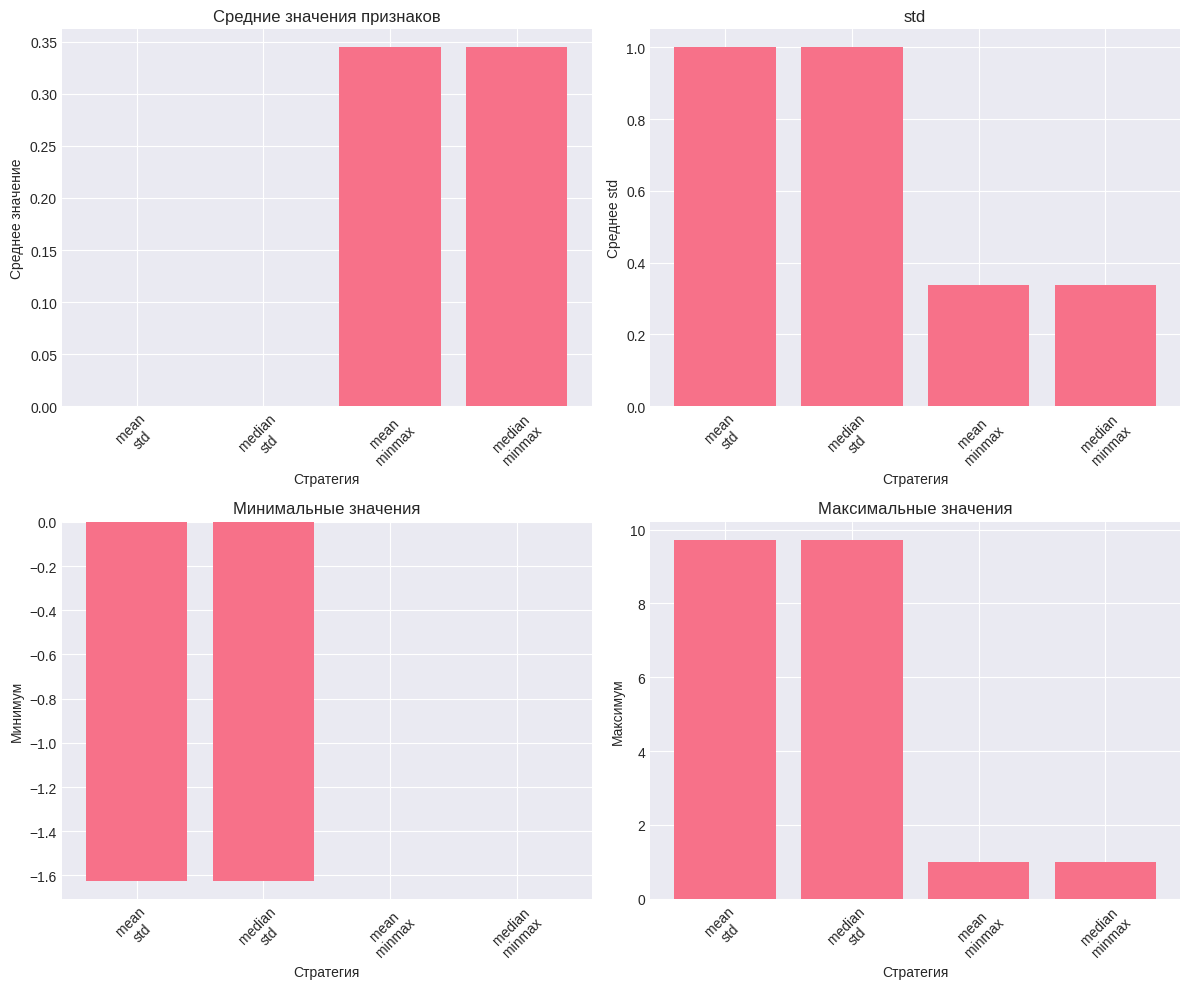

In [46]:
strategies=[
    {'missing_strategy': 'mean', 'normalize_method': 'std'},
    {'missing_strategy': 'median', 'normalize_method': 'std'},
    {'missing_strategy': 'mean', 'normalize_method': 'minmax'},
    {'missing_strategy': 'median', 'normalize_method': 'minmax'},
]
results=[]

for i, params in enumerate(strategies):
    print(f"\n Стратегия {i+1}: {params}")
    preprocessor=DataPreprocessor(df_titanic.copy())
    processed=preprocessor.fit_transform(
        missing_threshold=0.1,
        missing_strategy=params['missing_strategy'],
        encode_max_categories=3,
        normalize_method=params['normalize_method']
    )
    try:
        numeric_cols=processed.select_dtypes(include=['number']).columns
    except:
        numeric_cols=processed.select_dtypes(include=[np.number]).columns
    stats={
        'strategy': params['missing_strategy'],
        'normalization': params['normalize_method'],
        'mean': processed[numeric_cols].mean().mean(),
        'std': processed[numeric_cols].std().mean(),
        'min': processed[numeric_cols].min().min(),
        'max': processed[numeric_cols].max().max()
    }
    results.append(stats)
    print(f"   Среднее значение признаков: {stats['mean']:.4f}")
    print(f"   Среднее std признаков: {stats['std']:.4f}")
    print(f"   Диапазон: [{stats['min']:.4f}, {stats['max']:.4f}]")

results_df=pd.DataFrame(results)
print("\n")
print(results_df)

fig, axes=plt.subplots(2, 2, figsize=(12, 10))

#cредние значения
axes[0, 0].bar(range(len(results)), [r['mean'] for r in results])
axes[0, 0].set_title('Средние значения признаков')
axes[0, 0].set_xlabel('Стратегия')
axes[0, 0].set_ylabel('Среднее значение')
axes[0, 0].set_xticks(range(len(results)))
axes[0, 0].set_xticklabels([f"{r['strategy']}\n{r['normalization']}" for r in results], rotation=45)

#cтандартные отклонения
axes[0, 1].bar(range(len(results)), [r['std'] for r in results])
axes[0, 1].set_title('std')
axes[0, 1].set_xlabel('Стратегия')
axes[0, 1].set_ylabel('Среднее std')
axes[0, 1].set_xticks(range(len(results)))
axes[0, 1].set_xticklabels([f"{r['strategy']}\n{r['normalization']}" for r in results], rotation=45)

#минимальные
axes[1, 0].bar(range(len(results)), [r['min'] for r in results])
axes[1, 0].set_title('Минимальные значения')
axes[1, 0].set_xlabel('Стратегия')
axes[1, 0].set_ylabel('Минимум')
axes[1, 0].set_xticks(range(len(results)))
axes[1, 0].set_xticklabels([f"{r['strategy']}\n{r['normalization']}" for r in results], rotation=45)

#максимальные значения
axes[1, 1].bar(range(len(results)), [r['max'] for r in results])
axes[1, 1].set_title('Максимальные значения')
axes[1, 1].set_xlabel('Стратегия')
axes[1, 1].set_ylabel('Максимум')
axes[1, 1].set_xticks(range(len(results)))
axes[1, 1].set_xticklabels([f"{r['strategy']}\n{r['normalization']}" for r in results], rotation=45)

plt.tight_layout()
plt.show()